In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from lightgbm import LGBMClassifier
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import recall_score, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,cross_val_score

^ 라이브러리들을 import 합니다.

In [2]:
pd.set_option('display.max_row', 200)
pd.set_option('display.max_columns', 200)

^ 표기 생략을 방지하기 위해 max row,columns 값을 200으로 조절합니다.

In [3]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion=confusion_matrix(y_test,pred)
    accuracy=accuracy_score(y_test,pred)
    precision=precision_score(y_test,pred)
    recall=recall_score(y_test,pred)
    f1=f1_score(y_test,pred)
    roc_auc=roc_auc_score(y_test,pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}\
    F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy,precision,recall,f1,roc_auc))

^ 모델 평가 함수를 선언합니다

In [4]:
vote_df=pd.read_csv('PR2_train.csv')

^ csv 파일을 pandas를 이용하여 불러옵니다.

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le = le.fit(vote_df['race'])
vote_df['race'] = le.transform(vote_df['race'])
le = le.fit(vote_df['gender'])
vote_df['gender'] = le.transform(vote_df['gender'])
le = le.fit(vote_df['religion'])
vote_df['religion'] = le.transform(vote_df['religion'])
le = le.fit(vote_df['age_group'])
vote_df['age_group'] = le.transform(vote_df['age_group'])

^ age_group, gender, religion, race 항을 LabelEncoder를 사용하여 int로 변환합니다.

--> lightGBM모델은 int,float,bool값만 학습 가능하기 때문

In [6]:
vote_result=vote_df['voted']
droplist=['index','voted']
vote_drop_df=vote_df.drop(droplist,axis=1,inplace=True)

^ index, voted 항을 분리합니다.

--> index항은 항번호일뿐 학습하면 안됨, voted항은 결과이므로 학습하면 안됨.

In [7]:
vote_data=vote_df.copy()
X_train,X_test,y_train,y_test=train_test_split(vote_data, vote_result,
                                               test_size=0.2, random_state=0)
lgbm_wrapper=LGBMClassifier(n_estimators=400)
evals=[(X_test,y_test)]
lgbm_wrapper.fit(X_train,y_train,early_stopping_rounds=100,
                 eval_metric="logloss",eval_set=evals,verbose=True)
lg_pred=lgbm_wrapper.predict(X_test)
lg_pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.667544
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.650618
[3]	valid_0's binary_logloss: 0.636507
[4]	valid_0's binary_logloss: 0.624742
[5]	valid_0's binary_logloss: 0.614627
[6]	valid_0's binary_logloss: 0.605983
[7]	valid_0's binary_logloss: 0.599201
[8]	valid_0's binary_logloss: 0.593053
[9]	valid_0's binary_logloss: 0.587842
[10]	valid_0's binary_logloss: 0.583305
[11]	valid_0's binary_logloss: 0.579318
[12]	valid_0's binary_logloss: 0.576185
[13]	valid_0's binary_logloss: 0.573237
[14]	valid_0's binary_logloss: 0.570749
[15]	valid_0's binary_logloss: 0.568573
[16]	valid_0's binary_logloss: 0.566624
[17]	valid_0's binary_logloss: 0.564815
[18]	valid_0's binary_logloss: 0.563509
[19]	valid_0's binary_logloss: 0.562257
[20]	valid_0's binary_logloss: 0.561477
[21]	valid_0's binary_logloss: 0.56057
[22]	valid_0's binary_logloss: 0.559749
[23]	valid_0's binary_logloss: 0.55923
[24]	valid_0's binary_logloss

In [8]:
get_clf_eval(y_test,lg_pred,lg_pred_proba)

오차 행렬
[[2537 1461]
 [ 723 2564]]
정확도: 0.7002, 정밀도: 0.6370, 재현율: 0.7800    F1: 0.7013, AUC: 0.7724


^ 기본적인 LightGBM 모델을 만들고, 평가 함수로 점수를 출력합니다.

In [9]:
from scipy.stats import mode

zero_features=['engnat','education','urban','married','hand']
total_count=vote_df['engnat'].count()
for feature in zero_features:
    zero_count=vote_df[vote_df[feature]==0][feature].count()
    print('{0}건수는 {1}, 퍼센트는{2:.2f}%'.format(feature,zero_count,
                                            100*zero_count/total_count))
vote_df[zero_features]=vote_df[zero_features].replace(0,
                                        vote_df[zero_features].mean())
print('\n0값 제거 작업 후:')
for feature in zero_features:
    zero_count=vote_df[vote_df[feature]==0][feature].count()
    print('{0}건수는 {1}, 퍼센트는{2:.2f}%'.format(feature,zero_count,
                                            100*zero_count/total_count))

engnat건수는 63, 퍼센트는0.17%
education건수는 432, 퍼센트는1.19%
urban건수는 258, 퍼센트는0.71%
married건수는 74, 퍼센트는0.20%
hand건수는 135, 퍼센트는0.37%

0값 제거 작업 후:
engnat건수는 0, 퍼센트는0.00%
education건수는 0, 퍼센트는0.00%
urban건수는 0, 퍼센트는0.00%
married건수는 0, 퍼센트는0.00%
hand건수는 0, 퍼센트는0.00%


^ 무응답 값을 최빈값으로 대체합니다

In [10]:
vote_data=vote_df.copy()
X_train,X_test,y_train,y_test=train_test_split(vote_data, vote_result,
                                               test_size=0.2, random_state=0)
lgbm_wrapper=LGBMClassifier(n_estimators=400)
evals=[(X_test,y_test)]
lgbm_wrapper.fit(X_train,y_train,early_stopping_rounds=100,
                 eval_metric="logloss",eval_set=evals,verbose=True)
lg_pred=lgbm_wrapper.predict(X_test)
lg_pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.667435
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.650603
[3]	valid_0's binary_logloss: 0.636285
[4]	valid_0's binary_logloss: 0.624649
[5]	valid_0's binary_logloss: 0.614478
[6]	valid_0's binary_logloss: 0.605839
[7]	valid_0's binary_logloss: 0.598604
[8]	valid_0's binary_logloss: 0.592625
[9]	valid_0's binary_logloss: 0.587498
[10]	valid_0's binary_logloss: 0.582911
[11]	valid_0's binary_logloss: 0.578897
[12]	valid_0's binary_logloss: 0.575715
[13]	valid_0's binary_logloss: 0.572847
[14]	valid_0's binary_logloss: 0.57042
[15]	valid_0's binary_logloss: 0.568323
[16]	valid_0's binary_logloss: 0.566466
[17]	valid_0's binary_logloss: 0.564809
[18]	valid_0's binary_logloss: 0.563391
[19]	valid_0's binary_logloss: 0.562156
[20]	valid_0's binary_logloss: 0.561207
[21]	valid_0's binary_logloss: 0.560366
[22]	valid_0's binary_logloss: 0.559643
[23]	valid_0's binary_logloss: 0.558945
[24]	valid_0's binary_loglos

In [11]:
get_clf_eval(y_test,lg_pred,lg_pred_proba)

오차 행렬
[[2522 1476]
 [ 704 2583]]
정확도: 0.7008, 정밀도: 0.6364, 재현율: 0.7858    F1: 0.7032, AUC: 0.7735


^ 평가 함수로 점수를 출력합니다
(기본모델+무응답값처리)


F1점수가 0.0019 증가하였습니다.

(이전모델 F1: 0.7013)

In [12]:
def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis=1)
        data = data.drop(column, axis=1)
    return data

^ 원핫인코딩 함수를 선언합니다.

In [13]:
dummy_columns=['age_group','education','engnat',
               'married','race','religion','urban','hand']
vote_onehot_df = dummy_data(vote_df, dummy_columns)

^ 값의 우열이 없지만 우열처럼 인식될 수 있는 항목들을 원핫인코딩 시킵니다.

In [14]:
vote_df.head()

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,QfA,QfE,QgA,QgE,QhA,QhE,QiA,QiE,QjA,QjE,QkA,QkE,QlA,QlE,QmA,QmE,QnA,QnE,QoA,QoE,QpA,QpE,QqA,QqE,QrA,QrE,QsA,QsE,QtA,QtE,age_group,education,engnat,familysize,gender,hand,married,race,religion,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10,urban,wf_01,wf_02,wf_03,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
0,1.0,324,5.0,1067,5.0,359,1.0,709,1.0,742,1.0,330,5.0,541,5.0,1376,2.0,1397,5.0,1250,2.0,762,5.0,517,4.0,3614,1.0,521,5.0,705,4.0,633,1.0,330,1.0,512,5.0,347,5.0,588,2,3.0,1.0,2,1,1.0,1.0,6,3,2,2,1,5,2,4,5,4,1,2,2.0,0,1,0,1,1,0,1,1,1,1,1,0,1,0,1,1
1,1.0,534,5.0,1555,5.0,2024,1.0,1097,1.0,3077,3.0,6721,1.0,1306,4.0,2968,5.0,1998,5.0,2756,2.0,3429,5.0,2395,5.0,1745,1.0,584,5.0,1857,5.0,2894,2.0,3761,1.0,2717,3.0,2802,5.0,1299,1,2.0,2.0,4,1,1.0,1.0,1,7,1,0,2,2,0,6,1,5,5,6,3.0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,1,1
2,5.0,609,1.0,749,2.0,624,1.0,1833,3.0,1474,5.0,728,4.0,1107,3.0,1743,5.0,3008,3.0,1649,5.0,870,1.0,1551,1.0,989,5.0,347,1.0,824,1.0,1445,2.0,884,5.0,744,1.0,899,4.0,963,2,2.0,1.0,3,0,1.0,1.0,6,5,0,1,0,5,3,6,0,2,1,6,2.0,0,0,0,0,1,0,1,1,0,1,1,0,1,0,1,0
3,4.0,182,1.0,2969,1.0,1955,4.0,4630,1.0,1321,3.0,2345,4.0,850,1.0,3559,5.0,6761,1.0,8315,5.0,614,1.0,1751,1.0,1919,4.0,96,4.0,1251,5.0,261,4.0,548,4.0,2576,2.0,877,5.0,967,1,3.0,2.0,3,1,1.0,1.0,5,7,2,2,4,5,0,1,0,2,0,4,1.0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,1,1
4,4.0,549,5.0,1679,5.0,481,3.0,595,1.0,1202,1.0,348,1.0,422,2.0,2453,1.0,1051,5.0,4733,3.0,2705,5.0,773,4.0,775,2.0,1066,5.0,824,1.0,750,4.0,535,4.0,1000,4.0,964,5.0,683,2,2.0,1.0,4,0,1.0,1.0,6,10,6,3,6,2,0,6,2,0,6,4,2.0,0,0,0,1,1,0,1,1,0,1,1,1,1,1,1,1


In [15]:
vote_data=vote_onehot_df.copy()
X_train,X_test,y_train,y_test=train_test_split(vote_data, vote_result,
                                               test_size=0.2, random_state=0)
lgbm_wrapper=LGBMClassifier(n_estimators=400)
evals=[(X_test,y_test)]
lgbm_wrapper.fit(X_train,y_train,early_stopping_rounds=100,
                 eval_metric="logloss",eval_set=evals,verbose=True)
lg_pred=lgbm_wrapper.predict(X_test)
lg_pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.667553
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.650377
[3]	valid_0's binary_logloss: 0.636176
[4]	valid_0's binary_logloss: 0.624325
[5]	valid_0's binary_logloss: 0.614347
[6]	valid_0's binary_logloss: 0.606162
[7]	valid_0's binary_logloss: 0.599142
[8]	valid_0's binary_logloss: 0.593074
[9]	valid_0's binary_logloss: 0.587825
[10]	valid_0's binary_logloss: 0.583564
[11]	valid_0's binary_logloss: 0.5798
[12]	valid_0's binary_logloss: 0.576763
[13]	valid_0's binary_logloss: 0.573873
[14]	valid_0's binary_logloss: 0.571315
[15]	valid_0's binary_logloss: 0.569173
[16]	valid_0's binary_logloss: 0.567308
[17]	valid_0's binary_logloss: 0.565826
[18]	valid_0's binary_logloss: 0.564404
[19]	valid_0's binary_logloss: 0.563183
[20]	valid_0's binary_logloss: 0.562173
[21]	valid_0's binary_logloss: 0.561129
[22]	valid_0's binary_logloss: 0.56044
[23]	valid_0's binary_logloss: 0.559506
[24]	valid_0's binary_logloss:

In [16]:
get_clf_eval(y_test,lg_pred,lg_pred_proba)

오차 행렬
[[2522 1476]
 [ 748 2539]]
정확도: 0.6947, 정밀도: 0.6324, 재현율: 0.7724    F1: 0.6954, AUC: 0.7728


^ 평가 함수로 점수를 출력합니다 
(기본모델+무응답값처리+원핫인코딩)


F1점수가 이전모델에 비해 0.0078 감소하였습니다.

(이전모델 F1: 0.7032)

원핫인코딩은 이 모델에서 안 쓰는 것으로 하겠습니다.

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
vote_df[:]=scaler.fit_transform(vote_df[:])

In [18]:
vote_df.head()

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,QfA,QfE,QgA,QgE,QhA,QhE,QiA,QiE,QjA,QjE,QkA,QkE,QlA,QlE,QmA,QmE,QnA,QnE,QoA,QoE,QpA,QpE,QqA,QqE,QrA,QrE,QsA,QsE,QtA,QtE,age_group,education,engnat,familysize,gender,hand,married,race,religion,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10,urban,wf_01,wf_02,wf_03,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
0,0.00,0.000124,1.0,0.000322,1.00,0.000383,0.00,0.000440,0.0,0.000400,0.0,0.000026,1.00,0.000483,1.00,0.000741,0.25,0.000082,1.0,0.000126,0.25,0.000246,1.0,0.000006,0.75,0.000729,0.00,0.000818,1.00,0.000797,0.75,0.000136,0.00,0.000077,0.00,0.000015,1.00,0.000250,1.00,0.000085,0.333333,0.666667,0.0,0.002002,1.0,0.0,0.0,1.000000,0.272727,0.285714,0.285714,0.142857,0.714286,0.285714,0.571429,0.714286,0.571429,0.142857,0.285714,0.5,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
1,0.00,0.000211,1.0,0.000473,1.00,0.002294,0.00,0.000690,0.0,0.001705,0.5,0.000569,0.00,0.001199,0.75,0.001599,1.00,0.000117,1.0,0.000278,0.25,0.001107,1.0,0.000031,1.00,0.000350,0.00,0.000921,1.00,0.002147,1.00,0.000622,0.25,0.000879,0.00,0.000085,0.50,0.002158,1.00,0.000194,0.166667,0.333333,1.0,0.004004,1.0,0.0,0.0,0.166667,0.636364,0.142857,0.000000,0.285714,0.285714,0.000000,0.857143,0.142857,0.714286,0.714286,0.857143,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
2,1.00,0.000242,0.0,0.000224,0.25,0.000687,0.00,0.001164,0.5,0.000809,1.0,0.000060,0.75,0.001013,0.50,0.000939,1.00,0.000177,0.5,0.000166,1.00,0.000281,0.0,0.000020,0.00,0.000196,1.00,0.000531,0.00,0.000937,0.00,0.000311,0.25,0.000207,1.00,0.000023,0.00,0.000679,0.75,0.000142,0.333333,0.333333,0.0,0.003003,0.0,0.0,0.0,1.000000,0.454545,0.000000,0.142857,0.000000,0.714286,0.428571,0.857143,0.000000,0.285714,0.142857,0.857143,0.5,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.75,0.000065,0.0,0.000911,0.00,0.002214,0.75,0.002965,0.0,0.000724,0.5,0.000197,0.75,0.000772,0.00,0.001917,1.00,0.000397,0.0,0.000839,1.00,0.000198,0.0,0.000022,0.00,0.000385,0.75,0.000117,0.75,0.001437,1.00,0.000056,0.75,0.000128,0.75,0.000081,0.25,0.000662,1.00,0.000143,0.166667,0.666667,1.0,0.003003,1.0,0.0,0.0,0.833333,0.636364,0.285714,0.285714,0.571429,0.714286,0.000000,0.142857,0.000000,0.285714,0.000000,0.571429,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
4,0.75,0.000217,1.0,0.000512,1.00,0.000523,0.50,0.000366,0.0,0.000657,0.0,0.000027,0.00,0.000372,0.25,0.001321,0.00,0.000062,1.0,0.000478,0.50,0.000873,1.0,0.000010,0.75,0.000152,0.25,0.001716,1.00,0.000937,0.00,0.000161,0.75,0.000125,0.75,0.000031,0.75,0.000730,1.00,0.000100,0.333333,0.333333,0.0,0.004004,0.0,0.0,0.0,1.000000,0.909091,0.857143,0.428571,0.857143,0.285714,0.000000,0.857143,0.285714,0.000000,0.857143,0.571429,0.5,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


^ 다양한 범위로 이루어져있던 항들을 0.0 ~ 1.0의 float값으로 만들어주는 정규화입니다.

In [19]:
vote_data=vote_df.copy()
X_train,X_test,y_train,y_test=train_test_split(vote_data, vote_result,
                                               test_size=0.2, random_state=0)
lgbm_wrapper=LGBMClassifier(n_estimators=400)
evals=[(X_test,y_test)]
lgbm_wrapper.fit(X_train,y_train,early_stopping_rounds=100,
                 eval_metric="logloss",eval_set=evals,verbose=True)
lg_pred=lgbm_wrapper.predict(X_test)
lg_pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.667435
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.650603
[3]	valid_0's binary_logloss: 0.636285
[4]	valid_0's binary_logloss: 0.624649
[5]	valid_0's binary_logloss: 0.614478
[6]	valid_0's binary_logloss: 0.605839
[7]	valid_0's binary_logloss: 0.598604
[8]	valid_0's binary_logloss: 0.592625
[9]	valid_0's binary_logloss: 0.587498
[10]	valid_0's binary_logloss: 0.582911
[11]	valid_0's binary_logloss: 0.578897
[12]	valid_0's binary_logloss: 0.575715
[13]	valid_0's binary_logloss: 0.572847
[14]	valid_0's binary_logloss: 0.57042
[15]	valid_0's binary_logloss: 0.568323
[16]	valid_0's binary_logloss: 0.566466
[17]	valid_0's binary_logloss: 0.564809
[18]	valid_0's binary_logloss: 0.563391
[19]	valid_0's binary_logloss: 0.562156
[20]	valid_0's binary_logloss: 0.561207
[21]	valid_0's binary_logloss: 0.560366
[22]	valid_0's binary_logloss: 0.559643
[23]	valid_0's binary_logloss: 0.558945
[24]	valid_0's binary_loglos

In [20]:
get_clf_eval(y_test,lg_pred,lg_pred_proba)

오차 행렬
[[2529 1469]
 [ 704 2583]]
정확도: 0.7017, 정밀도: 0.6375, 재현율: 0.7858    F1: 0.7039, AUC: 0.7735


^ 평가 함수로 점수를 출력합니다
(기본모델+무응답값처리+정규화)


F1점수가 이전모델에 비해 0.0007 증가하였습니다.

(이전모델 F1: 0.7032)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

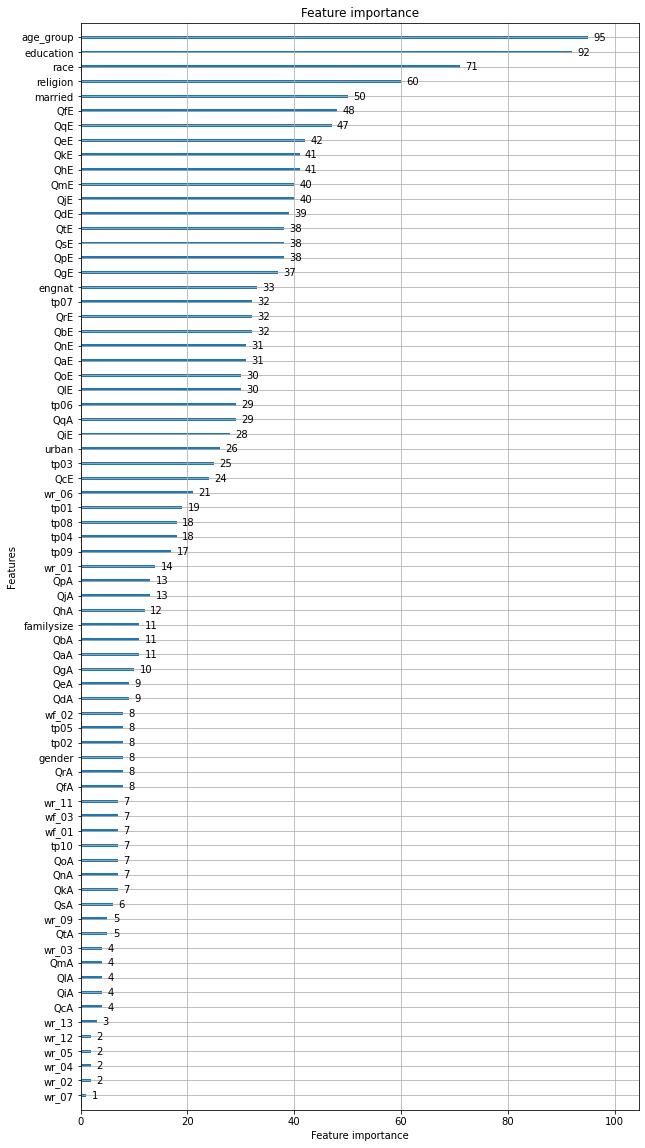

In [21]:
import matplotlib.pyplot as plt
from lightgbm import plot_importance

fig, ax= plt.subplots(figsize=(10,20))
plot_importance(lgbm_wrapper, ax=ax)

^ 이 모델의 피쳐중요도 순위입니다. 

In [22]:
vote_ft_df=vote_df.copy()
droplist=['wr_07','wr_02','wr_04','wr_05','wr_12']
vote_ft_df.drop(droplist,axis=1,inplace=True)

^ 피쳐중요도가 낮은 값 5개를 drop시킵니다.

In [23]:
vote_data=vote_ft_df.copy()
X_train,X_test,y_train,y_test=train_test_split(vote_data, vote_result,
                                               test_size=0.2, random_state=0)
lgbm_wrapper=LGBMClassifier(n_estimators=400)
evals=[(X_test,y_test)]
lgbm_wrapper.fit(X_train,y_train,early_stopping_rounds=100,
                 eval_metric="logloss",eval_set=evals,verbose=True)
lg_pred=lgbm_wrapper.predict(X_test)
lg_pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.667435
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.650603
[3]	valid_0's binary_logloss: 0.636285
[4]	valid_0's binary_logloss: 0.624649
[5]	valid_0's binary_logloss: 0.614478
[6]	valid_0's binary_logloss: 0.605839
[7]	valid_0's binary_logloss: 0.598604
[8]	valid_0's binary_logloss: 0.592625
[9]	valid_0's binary_logloss: 0.587498
[10]	valid_0's binary_logloss: 0.582911
[11]	valid_0's binary_logloss: 0.578897
[12]	valid_0's binary_logloss: 0.575715
[13]	valid_0's binary_logloss: 0.572847
[14]	valid_0's binary_logloss: 0.57044
[15]	valid_0's binary_logloss: 0.568389
[16]	valid_0's binary_logloss: 0.566533
[17]	valid_0's binary_logloss: 0.564916
[18]	valid_0's binary_logloss: 0.563479
[19]	valid_0's binary_logloss: 0.562244
[20]	valid_0's binary_logloss: 0.561307
[21]	valid_0's binary_logloss: 0.560533
[22]	valid_0's binary_logloss: 0.55979
[23]	valid_0's binary_logloss: 0.558988
[24]	valid_0's binary_logloss

In [24]:
get_clf_eval(y_test,lg_pred,lg_pred_proba)

오차 행렬
[[2533 1465]
 [ 729 2558]]
정확도: 0.6988, 정밀도: 0.6358, 재현율: 0.7782    F1: 0.6999, AUC: 0.7721


^ 평가 함수로 점수를 출력합니다 
(기본모델+무응답값처리+정규화+피쳐중요도)


F1 점수가 이전모델에 비해 0.0040 감소했습니다.

(이전모델 F1: 0.7039)

피쳐중요도 하위값 제외는 안 쓰는 것으로 하겠습니다.

In [32]:
vote_data=vote_df.copy()
X_train,X_test,y_train,y_test=train_test_split(vote_data, vote_result,
                                               test_size=0.2, random_state=0)
lgbm_wrapper=LGBMClassifier(n_estimators=400)
evals=[(X_test,y_test)]
lgbm_wrapper.fit(X_train,y_train,early_stopping_rounds=100,
                 eval_metric="logloss",eval_set=evals,verbose=True)
lg_pred=lgbm_wrapper.predict(X_test)
lg_pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.667435
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.650603
[3]	valid_0's binary_logloss: 0.636285
[4]	valid_0's binary_logloss: 0.624649
[5]	valid_0's binary_logloss: 0.614478
[6]	valid_0's binary_logloss: 0.605839
[7]	valid_0's binary_logloss: 0.598604
[8]	valid_0's binary_logloss: 0.592625
[9]	valid_0's binary_logloss: 0.587498
[10]	valid_0's binary_logloss: 0.582911
[11]	valid_0's binary_logloss: 0.578897
[12]	valid_0's binary_logloss: 0.575715
[13]	valid_0's binary_logloss: 0.572847
[14]	valid_0's binary_logloss: 0.57042
[15]	valid_0's binary_logloss: 0.568323
[16]	valid_0's binary_logloss: 0.566466
[17]	valid_0's binary_logloss: 0.564809
[18]	valid_0's binary_logloss: 0.563391
[19]	valid_0's binary_logloss: 0.562156
[20]	valid_0's binary_logloss: 0.561207
[21]	valid_0's binary_logloss: 0.560366
[22]	valid_0's binary_logloss: 0.559643
[23]	valid_0's binary_logloss: 0.558945
[24]	valid_0's binary_loglos

In [27]:
get_clf_eval(y_test,lg_pred,lg_pred_proba)

오차 행렬
[[2529 1469]
 [ 704 2583]]
정확도: 0.7017, 정밀도: 0.6375, 재현율: 0.7858    F1: 0.7039, AUC: 0.7735


^ 최종 모델입니다. F1점수: 0.7039

이제 test데이터에 실행시킵니다.

In [56]:
votest_df=pd.read_csv('PR2_test.csv')

^ 테스트 데이터가 있는 test.csv파일을 실행시킵니다.

In [88]:
votest_index=votest_df['index'].values


^엑셀파일에 붙혀넣을 인덱스 항목을 빼줍니다.

In [67]:
votest_data=votest_df.drop('index',axis=1,inplace=False)

^ test파일에서 인덱스를 뺀 데이터를 만듭니다.

In [89]:
votest_index

array([38741, 43904, 41036, ..., 41745, 24818, 33355], dtype=int64)

In [90]:
votest_data

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,QfA,QfE,QgA,QgE,QhA,QhE,QiA,QiE,QjA,QjE,QkA,QkE,QlA,QlE,QmA,QmE,QnA,QnE,QoA,QoE,QpA,QpE,QqA,QqE,QrA,QrE,QsA,QsE,QtA,QtE,age_group,education,engnat,familysize,gender,hand,married,race,religion,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10,urban,wf_01,wf_02,wf_03,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
0,0.00,0.001496,0.75,0.000671,1.00,0.001481,0.25,0.001120,1.00,0.000701,0.00,0.000118,0.25,0.024349,0.50,0.000018,1.00,0.000291,0.75,0.020071,0.75,0.001726,0.5,0.004894,0.50,0.000039,0.50,0.002902,0.50,0.000672,1.00,0.000494,0.25,0.001129,0.25,0.004965,0.75,0.001774,1.00,0.000081,0.333333,0.333333,0.0,4.656613e-10,1.0,0.0,0.0,1.000000,0.000000,0.571429,0.285714,0.142857,0.428571,0.000000,0.285714,0.714286,0.714286,0.000000,0.857143,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
1,0.25,0.000466,0.25,0.000132,0.50,0.000715,0.25,0.000608,0.25,0.000384,0.00,0.000492,0.50,0.002456,0.00,0.000013,0.50,0.000107,1.00,0.000507,0.50,0.000098,1.0,0.004758,0.75,0.000032,0.00,0.000476,0.75,0.000389,0.50,0.000407,0.00,0.000155,0.25,0.000873,0.50,0.000800,0.50,0.000071,0.500000,1.000000,0.0,9.313226e-10,0.0,0.0,0.5,1.000000,0.545455,0.714286,0.571429,0.142857,0.714286,0.285714,0.428571,0.000000,0.714286,0.000000,0.857143,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.25,0.000636,0.00,0.000962,0.00,0.000694,0.50,0.000606,0.75,0.000395,1.00,0.000103,1.00,0.000886,0.00,0.000012,1.00,0.000030,0.00,0.000690,1.00,0.000093,0.0,0.000682,0.25,0.000032,0.75,0.001084,0.25,0.001671,0.00,0.000138,1.00,0.000486,1.00,0.000849,0.50,0.000652,0.00,0.000044,0.166667,0.333333,0.0,9.313226e-10,0.0,0.0,0.0,1.000000,0.000000,0.285714,0.000000,0.285714,0.142857,0.000000,0.000000,0.142857,0.428571,0.571429,0.714286,0.5,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
3,0.25,0.001118,1.00,0.000502,0.25,0.003960,0.00,0.002581,0.00,0.000991,0.00,0.000180,0.00,0.008982,1.00,0.000011,0.00,0.000333,1.00,0.014043,1.00,0.000354,1.0,0.002350,1.00,0.000122,0.25,0.001515,1.00,0.001167,0.25,0.000787,0.50,0.000311,0.25,0.002067,0.00,0.008850,1.00,0.000186,0.166667,0.333333,1.0,4.656613e-10,1.0,0.0,0.0,1.000000,0.090909,0.142857,0.857143,0.000000,0.857143,0.000000,0.428571,0.571429,0.857143,0.000000,0.857143,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.00,0.000739,0.75,0.000121,0.75,0.001732,0.00,0.000416,0.00,0.000401,0.75,0.000183,0.75,0.000879,0.25,0.000010,1.00,0.000355,0.75,0.001236,0.75,0.000264,1.0,0.000661,1.00,0.000029,0.75,0.000680,0.25,0.000643,0.75,0.000352,0.25,0.000182,0.50,0.001523,1.00,0.000637,0.50,0.000104,0.333333,0.333333,0.0,9.313226e-10,1.0,0.5,0.0,1.000000,0.000000,0.571429,0.285714,0.285714,0.142857,0.000000,0.142857,0.142857,0.428571,0.428571,0.714286,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9102,0.00,0.000461,1.00,0.000131,1.00,0.001377,0.00,0.000838,0.00,0.000592,1.00,0.000112,1.00,0.001020,1.00,0.000013,1.00,0.000221,0.25,0.001954,1.00,0.000286,1.0,0.001736,1.00,0.000070,0.00,0.002465,1.00,0.000463,1.00,0.000336,0.00,0.000552,0.75,0.001550,0.50,0.001174,1.00,0.000046,0.166667,0.666667,1.0,9.313226e-10,1.0,0.0,0.0,1.000000,0.181818,0.571429,0.142857,0.285714,0.000000,0.000000,0.000000,0.428571,0.000000,0.857143,0.571429,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
9103,0.00,0.000494,0.75,0.000120,1.00,0.000859,0.00,0.000715,0.00,0.000383,0.00,0.000195,0.25,0.000829,1.00,0.000037,0.25,0.000088,1.00,0.001339,0.75,0.000114,0.5,0.000954,1.00,0.000037,0.25,0.000907,0.75,0.000333,0.75,0.000872,0.75,0.000513,0.25,0.001086,1.00,0.000652,0.75,0.000

^확인 결과 잘 빼졌습니다.

In [92]:
from scipy.stats import mode

zero_features=['engnat','education','urban','married','hand']
total_count=votest_data['engnat'].count()
for feature in zero_features:
    zero_count=votest_data[votest_data[feature]==0][feature].count()
    print('{0}건수는 {1}, 퍼센트는{2:.2f}%'.format(feature,zero_count,
                                            100*zero_count/total_count))
votest_data[zero_features]=votest_data[zero_features].replace(0,
                                        votest_data[zero_features].mean())
print('\n0값 제거 작업 후:')
for feature in zero_features:
    zero_count=votest_data[vote_data[feature]==0][feature].count()
    print('{0}건수는 {1}, 퍼센트는{2:.2f}%'.format(feature,zero_count,
                                            100*zero_count/total_count))

engnat건수는 6660, 퍼센트는73.13%
education건수는 1059, 퍼센트는11.63%
urban건수는 1801, 퍼센트는19.78%
married건수는 6337, 퍼센트는69.58%
hand건수는 7832, 퍼센트는86.00%

0값 제거 작업 후:
engnat건수는 18, 퍼센트는0.20%
education건수는 3310, 퍼센트는36.35%
urban건수는 3744, 퍼센트는41.11%
married건수는 23, 퍼센트는0.25%
hand건수는 38, 퍼센트는0.42%


<ipython-input-92-266065a01a3d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  zero_count=votest_data[vote_data[feature]==0][feature].count()
<ipython-input-92-266065a01a3d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  zero_count=votest_data[vote_data[feature]==0][feature].count()
<ipython-input-92-266065a01a3d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  zero_count=votest_data[vote_data[feature]==0][feature].count()
<ipython-input-92-266065a01a3d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  zero_count=votest_data[vote_data[feature]==0][feature].count()
<ipython-input-92-266065a01a3d>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  zero_count=votest_data[vote_data[feature]==0][feature].count()


기본 데이터에서 int값으로 바꾸기 +무응답값처리+정규화 를 최종 알고리즘으로 결정했으니 마찬가지로 테스트 파일을 동일하게  전처리 해줍니다

In [80]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le = le.fit(votest_data['race'])
votest_data['race'] = le.transform(votest_data['race'])
le = le.fit(votest_data['gender'])
votest_data['gender'] = le.transform(votest_data['gender'])
le = le.fit(votest_data['religion'])
votest_data['religion'] = le.transform(votest_data['religion'])
le = le.fit(votest_data['age_group'])
votest_data['age_group'] = le.transform(votest_data['age_group'])

In [83]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
votest_data[:]=scaler.fit_transform(votest_data[:])

In [86]:
lg_pred=lgbm_wrapper.predict(votest_data)
lg_pred_proba=lgbm_wrapper.predict_proba(votest_data)[:,1]

^ 학습이 완료된 모델에 test.csv의 데이터를 실행시킵니다.

In [94]:
df=pd.DataFrame([votest_index,lg_pred_proba,lg_pred])
df=df.transpose()
df.columns=['index','pred_prob','pred']
df.to_csv('test_submission.csv',index=False,encoding='cp949')

In [98]:
import sys
np.set_printoptions(threshold=sys.maxsize)

lg_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,

In [99]:
lg_pred_proba

array([0.41433142, 0.7440079 , 0.27568462, 0.48445446, 0.58599256,
       0.49416504, 0.6078226 , 0.02023126, 0.60469316, 0.68641138,
       0.01982919, 0.49380137, 0.72516274, 0.23431489, 0.72477525,
       0.3427831 , 0.02683186, 0.51470204, 0.55783785, 0.58632865,
       0.71687543, 0.13492788, 0.70291916, 0.42544653, 0.45863107,
       0.49180418, 0.73930201, 0.70044131, 0.66863466, 0.69185628,
       0.50191132, 0.56811262, 0.19364983, 0.57789562, 0.62527659,
       0.4131489 , 0.65313547, 0.71190416, 0.64657182, 0.29069091,
       0.75502095, 0.10488721, 0.44416506, 0.01678115, 0.27884175,
       0.43703235, 0.40723542, 0.23025612, 0.53060999, 0.29032543,
       0.35212788, 0.63603176, 0.79812788, 0.48440509, 0.687189  ,
       0.49511843, 0.72577688, 0.60739997, 0.41842429, 0.28592989,
       0.63729897, 0.13474149, 0.01897139, 0.71718457, 0.41066453,
       0.25865219, 0.0222569 , 0.46757008, 0.1460132 , 0.56796456,
       0.69203916, 0.67162607, 0.63085903, 0.72383774, 0.49033

위 예측값으로 엑셀파일 생성을 완료하였습니다.